In [7]:
#standard packages
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

## Read in data

In [8]:
#read in data
test_series  = pd.read_parquet("../../child-mind-institute-detect-sleep-states/test_series.parquet")
train_series = pd.read_parquet("../../child-mind-institute-detect-sleep-states/train_series.parquet")
train_events = pd.read_csv("../../child-mind-institute-detect-sleep-states/train_events.csv")

In [9]:
#take a look
train_series.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215


In [10]:
#take a look
train_events.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [11]:
def isolate_individuals(train_events, train_series, nth = 0, days="all"):
    """
    Function to isolate patient specific information.
    Parameters
    ----------
    train_events:
        dtype: pd.DataFrame()
        pandas df of train events
    train_series:
        dtype: pd.DataFrame()
        pandas df of train series
    nth:
        dtype: int
        which patient information is desired based on index
    days:
        dtype: int or string
        number of days to return for patient, if 'all' then 
        it will return all days
    """
    #unique ids
    ids = train_series.series_id.unique()
    
    #grab individual
    p1  = train_series[train_series.series_id == ids[nth]]
    #drop nans
    p1e = train_events[train_events.series_id == ids[nth]].dropna()
    
    #dates for individual
    dates = p1.timestamp.str.split("T").str[0].unique()
    
    #isolate data for given periods
    data = []
    events = []
    if days == "all":
        days = len(dates)
    for day in range(days):
        p1_info   = p1[p1.timestamp.str.startswith(dates[day])].reset_index(drop=True)
        p1_events = p1e[p1e.timestamp.str.startswith(dates[day])].reset_index(drop=True)
        data.append(p1_info)
        events.append(p1_events)
        
    df = pd.concat(data).reset_index(drop=True)
    dfe = pd.concat(events).reset_index(drop=True)
    
    return df, dfe

In [12]:
df, dfe = isolate_individuals(train_events, train_series, nth = 0, days="all")

In [13]:
df.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215


In [14]:
dfe.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


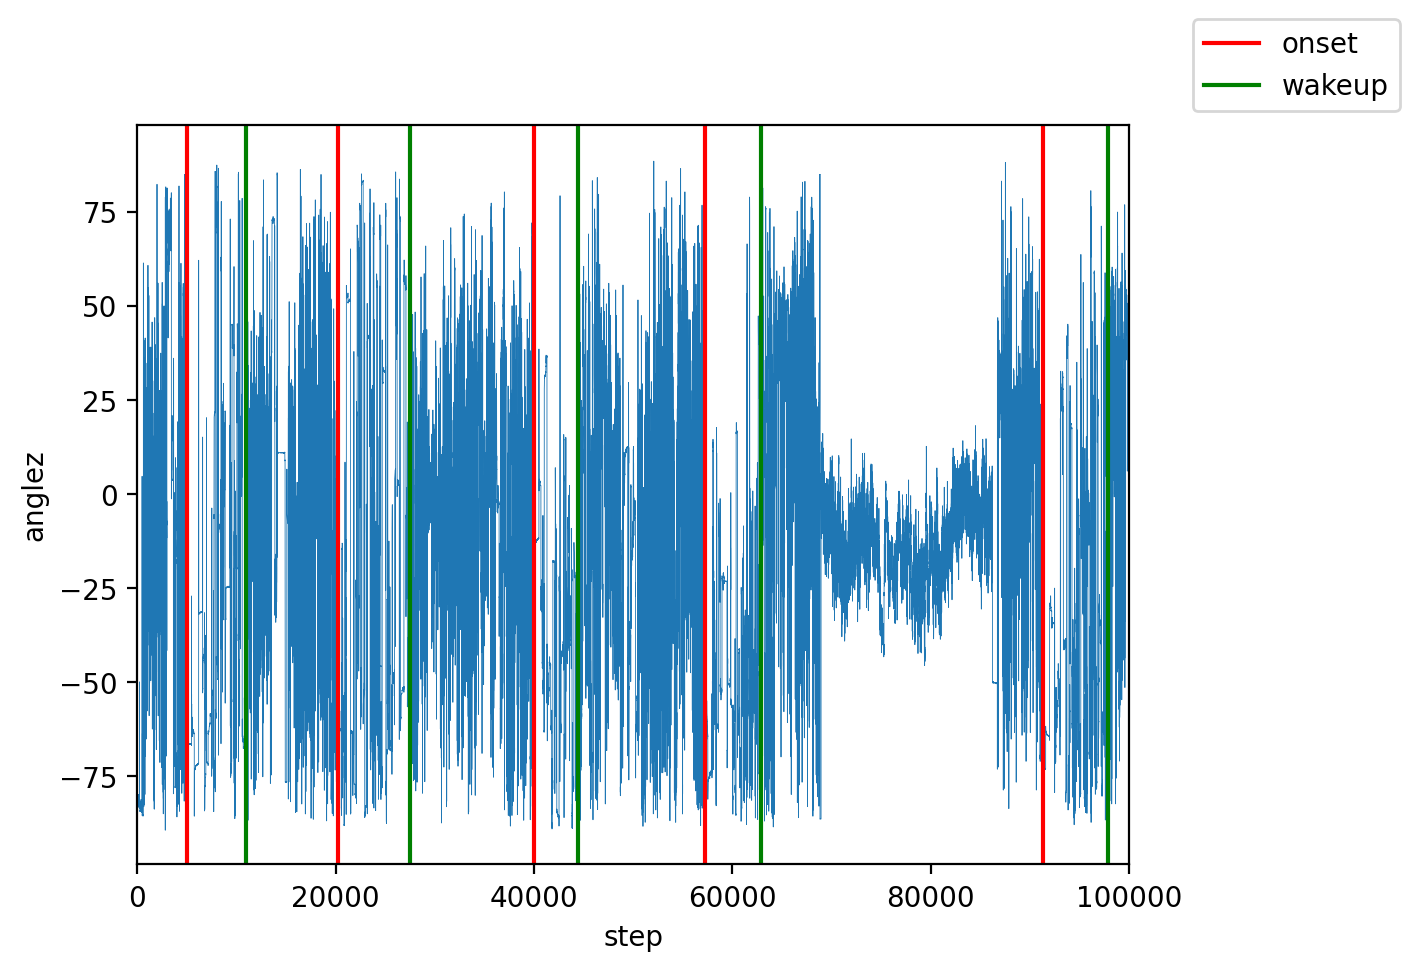

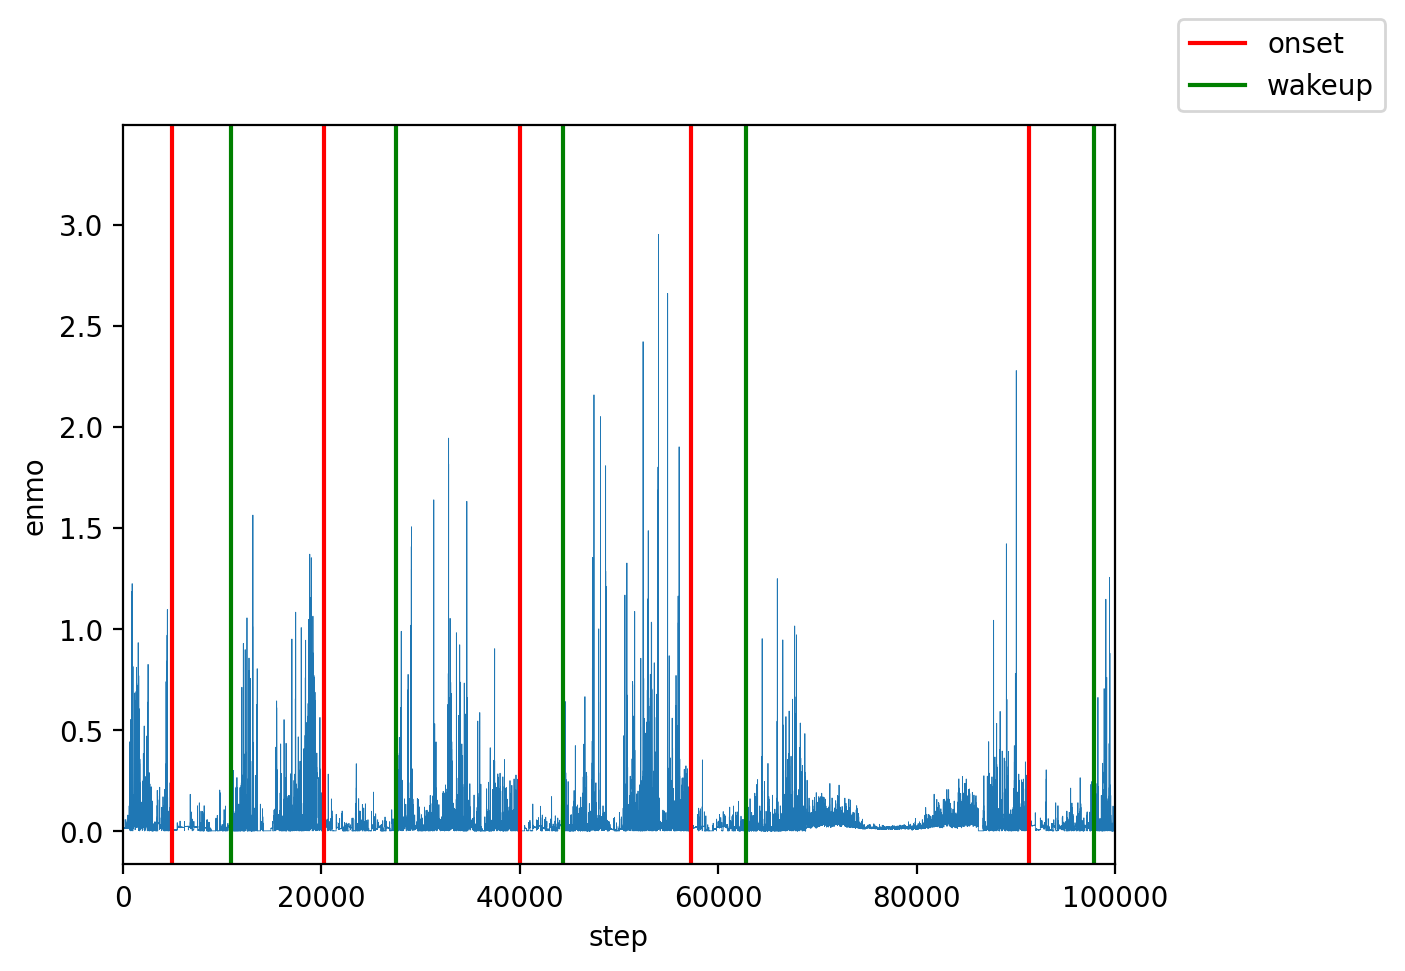

In [15]:
##desired range
step_range = [0,100000]

#plot anglez
plt.plot(df.step, df.anglez, lw=0.3)
for i in range(len(dfe)):
    if dfe.iloc[i].event == "onset":
        plt.axvline(dfe.iloc[i].step, color = "red", label = "onset")
    else:
        plt.axvline(dfe.iloc[i].step, color = "green", label = "wakeup")
plt.xlabel("step")
plt.ylabel("anglez")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1.0))
plt.xlim(step_range[0], step_range[1])
plt.show()

#plot enmo
plt.plot(df.step, df.enmo, lw=0.3)
for i in range(len(dfe)):
    if dfe.iloc[i].event == "onset":
        plt.axvline(dfe.iloc[i].step, color = "red", label = "onset")
    else:
        plt.axvline(dfe.iloc[i].step, color = "green", label = "wakeup")
plt.xlabel("step")
plt.ylabel("enmo")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1.0))
plt.xlim(step_range[0], step_range[1])
plt.show()

General Notes:

During onset, the enmo and anglez seems to have less spikes and variance in signal. The window size between onset and wakeup is much smaller than wakeup to onset. This makes sense considering an individual would be awake longer than asleep. Additionally, the wrist movement will also be much more during waking hours. Knowing this, we can think of doing some feaure engineering with the raw data to train a classifier or utilize BiLSTM models that takes in the raw data. 

Potential Things to Try:

Idea 1: <br>
We know what to essentially look for in this classification problem. Because this is a time series data and we need to identify specific steps that are onset or wakeup, we will need to create a sliding window algorithm. The sliding window should calculate some features in that window slice. More features would help with the classification. We can try to use a boosted tree algorithm for this problem. <br>
Key points: <br>
- Sliding window of user defined size
- Calculate variance in enmo and anglez window 
- Calculate total magnitude of windows (L1 Norm)
- Calculate slope change by linear regression or someother way to determine if person is undergoing onset or wakeup
    - If slope is negative then we know that is onsey. If slope is positive we know that is wakeup.
- Use boosted tree model to identify step window that contains exact onset or wakeup. To pick the exact step we may need to smooth by that window slice and run a mini sliding linear regressor to find the imediate time step where the slope is close to zero or is at its highest.

Idea 2: <br>
Usually, the best deep learning approach for time series is LSTM models. We can try to generate a biLSTM model where is looks at time series data in the forward and reverse direction. I'm assuming this approach is better for classification. We need to include a dense linear layer after biLSTM to assign nothing, onset, and wakeup labels. This will require quite a bit of deep neural network architecture building using pyTorch. 

# Boosted Trees

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [17]:
def sliding_window_statistics(data, window_size=10):
    """
    Perform a sliding window on time series data.

    Args:
    - data (list or numpy array): The time series data.
    - window_size (int): The size of the sliding window.

    Returns:
    - results_df (DataFrame): A DataFrame containing the variance, total magnitude 
      (L1 Norm), and change in slope (for L1 Norm) for each window.
    """
    if len(data) < window_size:
        raise ValueError("Data length should be greater than or equal to window size")

    # Ensure data is a list for easy manipulation
    if not isinstance(data, list):
        data = list(data)

    results = []
    prev_l1_norm = None

    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]

        # Calculate variance
        mean = sum(window) / window_size
        variance = sum([(x - mean)**2 for x in window]) / window_size

        # Calculate total magnitude (L1 Norm)
        l1_norm = sum([abs(x) for x in window])

        # Calculate change in slope for L1 Norm
        if prev_l1_norm is not None:
            change_in_slope = l1_norm - prev_l1_norm
        else:
            change_in_slope = 0  # or np.nan depending on your preference for the first window

        results.append({
            "variance": variance,
            "l1_norm": l1_norm,
            "change_in_slope": change_in_slope
        })

        prev_l1_norm = l1_norm

    results_df = pd.DataFrame(results)
    return results_df

In [29]:
collect_df = []
collect_dfe = []
#take 25 individuals
for i in range(25):
    df, dfe = isolate_individuals(train_events, train_series, nth = i, days="all")
    collect_df.append(df)
    collect_dfe.append(dfe)

In [30]:
#combine all to generate one long window
df = pd.concat(collect_df).reset_index(drop=True)
dfe = pd.concat(collect_dfe).reset_index(drop=True)

In [31]:
#30 time step slice (2.5h window)
window_size = 30
stat = sliding_window_statistics(df.enmo.values, window_size=window_size)

In [32]:
#data
event_times = dfe.step.values
data = df.enmo.values

# Assign labels to windows based on event times
labels = []
for i in range(len(data) - window_size + 1):
    if any([i <= event <= i + window_size for event in event_times]):
        labels.append(1) # Event occurs within this window
    else:
        labels.append(0) # No event within this window
print("training model...")
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(stat, labels, test_size=0.4, random_state=42)

# Train a Gradient Boosted Trees classifier
# Include GridSearchCV for hyperparameter tuning
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, 
                                 random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
print("generating predictions...")
# Predict on the testing set
y_pred = clf.predict(X_test)

# Evaluate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

training model...


TypeError: GradientBoostingClassifier.__init__() got an unexpected keyword argument 'n_jobs'

In [ ]:
np.sum(y_pred)

In [51]:
def pinpoint_event(data, window_start, window_size):
    """
    Identify the exact moment (index) of the steepest increase (wakeup) or decrease (onset) in the data.

    Args:
    - data (list or numpy array): The entire time series data.
    - window_start (int): Starting index of the window in the original time series data.
    - window_size (int): Size of the window.

    Returns:
    - event_idx (int): The index of the onset or wakeup event in the original time series data.
    - event_type (str): Either "onset" or "wakeup" based on the detected event.
    """
    max_change = 0
    event_idx = None
    event_type = None
    
    window_end = window_start + window_size
    for i in range(window_start + 1, window_end):
        change = data[i] - data[i-1]
        
        if abs(change) > abs(max_change):
            max_change = change
            event_idx = i
            
    event_type = "wakeup" if max_change > 0 else "onset"
    
    return event_idx, event_type

In [45]:
labels = []
for idx, prediction in enumerate(y_pred):
    if prediction == 1:  # if the window is predicted to contain an event
        window_start = idx * window_size
        event_time, event_type = pinpoint_event(data, window_start, window_size)
        labels.append([event_time, event_type])

In [46]:
labels

[]